# Experiment 9

In [1]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 17.9 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
! mkdir ~/.kaggle

In [3]:
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 97% 277M/285M [00:00<00:00, 402MB/s]
100% 285M/285M [00:00<00:00, 470MB/s]


In [6]:
! unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip

Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [7]:
!pip install wandb onnx -Uq

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import wandb
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [10]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: konstantine25b (konstantine25b-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [11]:
import os

In [12]:
class FER2013Dataset(Dataset):
    def __init__(self, data_source, transform=None):
        if isinstance(data_source, str):
           self.data = pd.read_csv(data_source)
        else:
           self.data = data_source
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.iloc[idx]['pixels']
        emotion = self.data.iloc[idx]['emotion']

        image = np.array([int(pixel) for pixel in pixels.split()]).reshape(48, 48)
        image = image.astype(np.float32) / 255.0

        if self.transform:
            image = self.transform(image)
        else:
            image = torch.FloatTensor(image).unsqueeze(0)

        return image, emotion

In [13]:
def get_transforms():
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Pad(4),
        transforms.RandomCrop(48),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    val_test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    return train_transform, val_test_transform

In [14]:
def create_train_val_test_splits(csv_file):
    data = pd.read_csv(csv_file)

    train_size = int(0.72 * len(data))
    val_size = int(0.18 * len(data))
    test_size = len(data) - train_size - val_size

    train_data = data.iloc[:train_size]
    val_data = data.iloc[train_size:train_size + val_size]
    test_data = data.iloc[train_size + val_size:]

    return train_data, val_data, test_data

In [15]:
def create_dataloaders(csv_file, batch_size=64):
    train_transform, val_test_transform = get_transforms()

    train_data, val_data, test_data = create_train_val_test_splits(csv_file)

    train_dataset = FER2013Dataset(train_data, transform=train_transform)
    val_dataset = FER2013Dataset(val_data, transform=val_test_transform)
    test_dataset = FER2013Dataset(test_data, transform=val_test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader

In [16]:
def create_test_loader(test_csv_path, batch_size=64):
    """Create test dataloader from CSV file"""
    _, val_test_transform = get_transforms()
    test_dataset = FER2013Dataset(test_csv_path, transform=val_test_transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    return test_loader

In [17]:
def load_model(model_path):
    """Load trained model from checkpoint"""
    checkpoint = torch.load(model_path, map_location=device)
    model_config = checkpoint['model_config']

    model = EnhancedCNN(
        dropout_rate=model_config['dropout_rate'],
        hidden_dim=model_config['hidden_dim']
    ).to(device)

    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Model loaded from {model_path}")
    return model

In [18]:
class BasicResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [19]:
class EnhancedCNN(nn.Module):
    def __init__(self, dropout_rate=0.3, hidden_dim=128):
        super(EnhancedCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.resnet_block = BasicResidualBlock(64, 128, stride=2)

        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(128 * 3 * 3, hidden_dim)
        self.bn4 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, 7)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))

        x = self.resnet_block(x)

        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.dropout1(x)
        x = self.fc2(x)

        return x

    def test(self, test_loader):
        """Simple test function like in the PyTorch tutorial"""
        self.eval()

        with torch.no_grad():
            correct, total = 0, 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            accuracy = correct / total
            print(f"Accuracy of the model on the {total} test images: {accuracy:.1%}")

            # Log to wandb if active
            if wandb.run is not None:
                wandb.log({"test_accuracy": accuracy})

            return accuracy

In [20]:
def test_overfitting():
    print("Testing enhanced CNN with ResNet block on small dataset...")

    model = EnhancedCNN(dropout_rate=0.0).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_loader, _, _ = create_dataloaders('train.csv', batch_size=32)

    small_batch = []
    for i, (data, target) in enumerate(train_loader):
        small_batch.extend(list(zip(data, target)))
        if len(small_batch) >= 20:
            break

    small_batch = small_batch[:20]

    for epoch in range(30):
        model.train()
        total_loss = 0
        correct = 0

        batch_data = []
        batch_targets = []

        for data, target in small_batch:
            batch_data.append(data)
            batch_targets.append(target)

        batch_data = torch.stack(batch_data).to(device)
        batch_targets = torch.tensor(batch_targets).to(device)

        optimizer.zero_grad()
        output = model(batch_data)
        loss = criterion(output, batch_targets)
        loss.backward()
        optimizer.step()

        total_loss = loss.item()
        pred = output.argmax(dim=1)
        correct = pred.eq(batch_targets).sum().item()

        accuracy = 100. * correct / len(small_batch)

        print(f"Overfit Epoch {epoch+1}/30, Loss: {total_loss:.4f}, Acc: {accuracy:.2f}%")

        if accuracy >= 95.0:
            print("Enhanced CNN can overfit successfully!")
            break

    print("Overfitting test completed.\n")

In [21]:
def compute_loss(loader, model, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

    return total_loss / len(loader), 100. * correct / total

In [22]:
def train_model(config=None):
    with wandb.init(project="Facial_Expression_Recognition_9", config=config):
        config = wandb.config

        model = EnhancedCNN(dropout_rate=config.dropout_rate, hidden_dim=config.hidden_dim).to(device)
        train_loader, val_loader, test_loader = create_dataloaders('train.csv', config.batch_size)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5, verbose=True)

        best_val_acc = 0
        best_model_path = f"best_model_{wandb.run.id}.pt"
        patience_counter = 0

        wandb.watch(model, log="gradients", log_freq=100)

        for epoch in range(config.epochs):
            model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0

            progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config.epochs} [Train]')

            for batch_idx, (data, target) in enumerate(progress_bar):
                data, target = data.to(device), target.to(device)

                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                pred = output.argmax(dim=1)
                train_correct += pred.eq(target).sum().item()
                train_total += target.size(0)

                if batch_idx % 50 == 0:
                    wandb.log({
                        "batch_loss": loss.item(),
                        "learning_rate": optimizer.param_groups[0]['lr'],
                        "epoch": epoch
                    })

                progress_bar.set_postfix({
                    'loss': f'{loss.item():.3f}',
                    'acc': f'{100.*train_correct/train_total:.1f}%'
                })

            train_acc = 100. * train_correct / train_total
            train_loss = train_loss / len(train_loader)

            val_loss, val_acc = compute_loss(val_loader, model, criterion, device)

            scheduler.step(val_acc)

            wandb.log({
                "epoch": epoch,
                "train_loss": train_loss,
                "train_accuracy": train_acc,
                "val_loss": val_loss,
                "val_accuracy": val_acc,
                "train_val_gap": train_acc - val_acc
            })

            print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0

                torch.save({
                    'model_state_dict': model.state_dict(),
                    'model_config': {
                        'dropout_rate': config.dropout_rate,
                        'hidden_dim': config.hidden_dim
                    },
                    'training_config': dict(config),
                    'val_accuracy': val_acc,
                    'epoch': epoch
                }, best_model_path)

                model_artifact = wandb.Artifact(
                    name=f"best_model_{wandb.run.name}",
                    type="model",
                    description=f"Best enhanced CNN model with validation accuracy: {val_acc:.2f}%"
                )
                model_artifact.add_file(best_model_path)
                wandb.log_artifact(model_artifact)

                print(f"New best model saved with validation accuracy: {val_acc:.2f}%")
            else:
                patience_counter += 1

            if patience_counter >= config.patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

        wandb.log({"best_val_accuracy": best_val_acc})
        print(f"Training completed. Best validation accuracy: {best_val_acc:.2f}%")

        return best_val_acc


In [23]:
def evaluate_model_on_testset(model_path, test_loader):
    checkpoint = torch.load(model_path, map_location=device)

    model_config = checkpoint['model_config']
    model = EnhancedCNN(
        dropout_rate=model_config['dropout_rate'],
        hidden_dim=model_config['hidden_dim']
    ).to(device)

    model.load_state_dict(checkpoint['model_state_dict'])

    criterion = nn.CrossEntropyLoss()
    test_loss, test_acc = compute_loss(test_loader, model, criterion, device)

    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")

    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

    print("\nClassification Report:")
    print(classification_report(all_targets, all_preds, target_names=emotion_labels))

    cm = confusion_matrix(all_targets, all_preds)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_labels, yticklabels=emotion_labels)
    plt.title('Confusion Matrix - Facial Expression Recognition (Enhanced CNN)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    return test_acc, all_preds, all_targets


In [24]:
best_config = {
    'batch_size': 64,
    'dropout_rate': 0.35,
    'epochs': 40,
    'hidden_dim': 256,
    'learning_rate': 0.002,
    'weight_decay': 0.00018,
    'patience': 8
}

In [25]:
test_overfitting()

Testing enhanced CNN with ResNet block on small dataset...
Overfit Epoch 1/30, Loss: 1.8771, Acc: 25.00%
Overfit Epoch 2/30, Loss: 0.7827, Acc: 100.00%
Enhanced CNN can overfit successfully!
Overfitting test completed.



In [26]:
print("Training enhanced CNN with best hyperparameters...")
best_val_acc = train_model(best_config)
print(f"\nTraining completed with validation accuracy: {best_val_acc:.2f}%")

Training enhanced CNN with best hyperparameters...


Epoch 1/40 [Train]: 100%|██████████| 323/323 [03:03<00:00,  1.76it/s, loss=1.417, acc=35.6%]


Epoch 1/40, Train Loss: 1.6357, Train Acc: 35.63%, Val Loss: 1.4267, Val Acc: 44.67%
New best model saved with validation accuracy: 44.67%


Epoch 2/40 [Train]: 100%|██████████| 323/323 [02:44<00:00,  1.96it/s, loss=1.349, acc=46.1%]


Epoch 2/40, Train Loss: 1.4005, Train Acc: 46.07%, Val Loss: 1.2977, Val Acc: 50.40%
New best model saved with validation accuracy: 50.40%


Epoch 3/40 [Train]: 100%|██████████| 323/323 [02:44<00:00,  1.96it/s, loss=1.452, acc=49.2%]


Epoch 3/40, Train Loss: 1.3128, Train Acc: 49.18%, Val Loss: 1.2475, Val Acc: 53.38%
New best model saved with validation accuracy: 53.38%


Epoch 4/40 [Train]: 100%|██████████| 323/323 [02:46<00:00,  1.93it/s, loss=1.311, acc=51.0%]


Epoch 4/40, Train Loss: 1.2702, Train Acc: 51.05%, Val Loss: 1.2026, Val Acc: 54.42%
New best model saved with validation accuracy: 54.42%


Epoch 5/40 [Train]: 100%|██████████| 323/323 [02:46<00:00,  1.94it/s, loss=1.208, acc=52.8%]


Epoch 5/40, Train Loss: 1.2340, Train Acc: 52.76%, Val Loss: 1.1732, Val Acc: 56.80%
New best model saved with validation accuracy: 56.80%


Epoch 6/40 [Train]: 100%|██████████| 323/323 [02:47<00:00,  1.93it/s, loss=1.245, acc=54.0%]


Epoch 6/40, Train Loss: 1.2082, Train Acc: 53.96%, Val Loss: 1.2941, Val Acc: 51.79%


Epoch 7/40 [Train]: 100%|██████████| 323/323 [02:45<00:00,  1.95it/s, loss=0.959, acc=54.6%]


Epoch 7/40, Train Loss: 1.1958, Train Acc: 54.61%, Val Loss: 1.1290, Val Acc: 58.20%
New best model saved with validation accuracy: 58.20%


Epoch 8/40 [Train]: 100%|██████████| 323/323 [02:48<00:00,  1.92it/s, loss=1.047, acc=55.3%]


Epoch 8/40, Train Loss: 1.1711, Train Acc: 55.32%, Val Loss: 1.1263, Val Acc: 58.16%


Epoch 9/40 [Train]: 100%|██████████| 323/323 [02:47<00:00,  1.93it/s, loss=0.896, acc=55.8%]


Epoch 9/40, Train Loss: 1.1584, Train Acc: 55.80%, Val Loss: 1.1813, Val Acc: 56.18%


Epoch 10/40 [Train]: 100%|██████████| 323/323 [02:46<00:00,  1.94it/s, loss=1.378, acc=56.5%]


Epoch 10/40, Train Loss: 1.1473, Train Acc: 56.53%, Val Loss: 1.1072, Val Acc: 58.82%
New best model saved with validation accuracy: 58.82%


Epoch 11/40 [Train]: 100%|██████████| 323/323 [02:43<00:00,  1.98it/s, loss=1.123, acc=56.7%]


Epoch 11/40, Train Loss: 1.1363, Train Acc: 56.72%, Val Loss: 1.0898, Val Acc: 59.45%
New best model saved with validation accuracy: 59.45%


Epoch 12/40 [Train]: 100%|██████████| 323/323 [02:44<00:00,  1.96it/s, loss=1.169, acc=57.2%]


Epoch 12/40, Train Loss: 1.1208, Train Acc: 57.16%, Val Loss: 1.0983, Val Acc: 58.56%


Epoch 13/40 [Train]: 100%|██████████| 323/323 [02:45<00:00,  1.95it/s, loss=0.970, acc=57.6%]


Epoch 13/40, Train Loss: 1.1146, Train Acc: 57.61%, Val Loss: 1.1077, Val Acc: 58.18%


Epoch 14/40 [Train]: 100%|██████████| 323/323 [02:42<00:00,  1.98it/s, loss=1.140, acc=57.8%]


Epoch 14/40, Train Loss: 1.1051, Train Acc: 57.76%, Val Loss: 1.0960, Val Acc: 58.41%


Epoch 15/40 [Train]: 100%|██████████| 323/323 [02:46<00:00,  1.94it/s, loss=1.119, acc=58.5%]


Epoch 15/40, Train Loss: 1.0994, Train Acc: 58.50%, Val Loss: 1.0795, Val Acc: 59.90%
New best model saved with validation accuracy: 59.90%


Epoch 16/40 [Train]: 100%|██████████| 323/323 [02:47<00:00,  1.93it/s, loss=1.026, acc=58.5%]


Epoch 16/40, Train Loss: 1.0953, Train Acc: 58.46%, Val Loss: 1.0998, Val Acc: 59.34%


Epoch 17/40 [Train]: 100%|██████████| 323/323 [02:52<00:00,  1.87it/s, loss=1.303, acc=59.1%]


Epoch 17/40, Train Loss: 1.0798, Train Acc: 59.07%, Val Loss: 1.0734, Val Acc: 60.44%
New best model saved with validation accuracy: 60.44%


Epoch 18/40 [Train]: 100%|██████████| 323/323 [02:45<00:00,  1.95it/s, loss=0.904, acc=59.3%]


Epoch 18/40, Train Loss: 1.0775, Train Acc: 59.30%, Val Loss: 1.0779, Val Acc: 60.36%


Epoch 19/40 [Train]: 100%|██████████| 323/323 [02:47<00:00,  1.93it/s, loss=1.277, acc=59.3%]


Epoch 19/40, Train Loss: 1.0780, Train Acc: 59.25%, Val Loss: 1.0983, Val Acc: 59.01%


Epoch 20/40 [Train]: 100%|██████████| 323/323 [02:47<00:00,  1.92it/s, loss=1.028, acc=59.3%]


Epoch 20/40, Train Loss: 1.0716, Train Acc: 59.30%, Val Loss: 1.1043, Val Acc: 59.80%


Epoch 21/40 [Train]: 100%|██████████| 323/323 [02:45<00:00,  1.95it/s, loss=0.928, acc=60.2%]


Epoch 21/40, Train Loss: 1.0586, Train Acc: 60.16%, Val Loss: 1.1017, Val Acc: 58.04%


Epoch 22/40 [Train]: 100%|██████████| 323/323 [02:44<00:00,  1.96it/s, loss=1.097, acc=62.2%]


Epoch 22/40, Train Loss: 1.0038, Train Acc: 62.16%, Val Loss: 1.0222, Val Acc: 62.47%
New best model saved with validation accuracy: 62.47%


Epoch 23/40 [Train]: 100%|██████████| 323/323 [02:46<00:00,  1.93it/s, loss=0.867, acc=63.0%]


Epoch 23/40, Train Loss: 0.9844, Train Acc: 62.99%, Val Loss: 1.0435, Val Acc: 61.58%


Epoch 24/40 [Train]: 100%|██████████| 323/323 [02:47<00:00,  1.93it/s, loss=1.129, acc=63.4%]


Epoch 24/40, Train Loss: 0.9787, Train Acc: 63.44%, Val Loss: 1.0045, Val Acc: 62.34%


Epoch 25/40 [Train]: 100%|██████████| 323/323 [02:45<00:00,  1.95it/s, loss=0.877, acc=63.5%]


Epoch 25/40, Train Loss: 0.9685, Train Acc: 63.54%, Val Loss: 1.0121, Val Acc: 63.21%
New best model saved with validation accuracy: 63.21%


Epoch 26/40 [Train]: 100%|██████████| 323/323 [02:48<00:00,  1.92it/s, loss=0.913, acc=64.1%]


Epoch 26/40, Train Loss: 0.9531, Train Acc: 64.06%, Val Loss: 1.0208, Val Acc: 62.76%


Epoch 27/40 [Train]: 100%|██████████| 323/323 [02:48<00:00,  1.91it/s, loss=0.942, acc=63.9%]


Epoch 27/40, Train Loss: 0.9507, Train Acc: 63.93%, Val Loss: 0.9931, Val Acc: 63.69%
New best model saved with validation accuracy: 63.69%


Epoch 28/40 [Train]: 100%|██████████| 323/323 [02:50<00:00,  1.89it/s, loss=1.053, acc=64.4%]


Epoch 28/40, Train Loss: 0.9404, Train Acc: 64.39%, Val Loss: 1.0048, Val Acc: 63.73%
New best model saved with validation accuracy: 63.73%


Epoch 29/40 [Train]: 100%|██████████| 323/323 [02:59<00:00,  1.80it/s, loss=0.958, acc=64.8%]


Epoch 29/40, Train Loss: 0.9360, Train Acc: 64.81%, Val Loss: 1.0203, Val Acc: 62.67%


Epoch 30/40 [Train]: 100%|██████████| 323/323 [03:09<00:00,  1.70it/s, loss=1.067, acc=65.7%]


Epoch 30/40, Train Loss: 0.9331, Train Acc: 65.71%, Val Loss: 1.0394, Val Acc: 62.86%


Epoch 31/40 [Train]: 100%|██████████| 323/323 [03:24<00:00,  1.58it/s, loss=0.841, acc=65.2%]


Epoch 31/40, Train Loss: 0.9276, Train Acc: 65.20%, Val Loss: 1.0105, Val Acc: 63.73%


Epoch 32/40 [Train]: 100%|██████████| 323/323 [03:49<00:00,  1.41it/s, loss=1.066, acc=65.5%]


Epoch 32/40, Train Loss: 0.9160, Train Acc: 65.51%, Val Loss: 1.0062, Val Acc: 64.10%
New best model saved with validation accuracy: 64.10%


Epoch 33/40 [Train]: 100%|██████████| 323/323 [04:22<00:00,  1.23it/s, loss=0.822, acc=65.4%]


Epoch 33/40, Train Loss: 0.9153, Train Acc: 65.40%, Val Loss: 1.0174, Val Acc: 63.73%


Epoch 34/40 [Train]: 100%|██████████| 323/323 [05:02<00:00,  1.07it/s, loss=1.286, acc=65.7%]


Epoch 34/40, Train Loss: 0.9051, Train Acc: 65.73%, Val Loss: 1.0385, Val Acc: 62.76%


Epoch 35/40 [Train]: 100%|██████████| 323/323 [05:56<00:00,  1.10s/it, loss=0.875, acc=66.1%]


Epoch 35/40, Train Loss: 0.9016, Train Acc: 66.07%, Val Loss: 1.0072, Val Acc: 63.40%


Epoch 36/40 [Train]: 100%|██████████| 323/323 [06:51<00:00,  1.27s/it, loss=1.251, acc=66.2%]


Epoch 36/40, Train Loss: 0.9026, Train Acc: 66.15%, Val Loss: 1.0113, Val Acc: 62.98%


Epoch 37/40 [Train]: 100%|██████████| 323/323 [07:30<00:00,  1.39s/it, loss=0.800, acc=68.0%]


Epoch 37/40, Train Loss: 0.8557, Train Acc: 68.03%, Val Loss: 1.0026, Val Acc: 64.41%
New best model saved with validation accuracy: 64.41%


Epoch 38/40 [Train]: 100%|██████████| 323/323 [07:53<00:00,  1.47s/it, loss=0.832, acc=68.9%]


Epoch 38/40, Train Loss: 0.8412, Train Acc: 68.93%, Val Loss: 0.9967, Val Acc: 65.20%
New best model saved with validation accuracy: 65.20%


Epoch 39/40 [Train]: 100%|██████████| 323/323 [08:14<00:00,  1.53s/it, loss=0.854, acc=69.1%]


Epoch 39/40, Train Loss: 0.8268, Train Acc: 69.05%, Val Loss: 1.0000, Val Acc: 64.91%


Epoch 40/40 [Train]: 100%|██████████| 323/323 [08:35<00:00,  1.60s/it, loss=0.690, acc=69.7%]


Epoch 40/40, Train Loss: 0.8138, Train Acc: 69.70%, Val Loss: 1.0055, Val Acc: 64.45%
Training completed. Best validation accuracy: 65.20%


batch_loss,██▆▅▅▄▅▅▄▄▄▄▅▄▃▅▄▅▄▃▅▄▄▃▅▄▂▃▂▅▃▃▃▃▄▄▄▃▃▁
best_val_accuracy,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇██
learning_rate,████████████████████▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁
train_accuracy,▁▃▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████
train_loss,█▆▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
train_val_gap,▁▃▃▄▃▆▄▄▅▄▄▅▅▅▅▅▅▅▆▅▆▅▆▆▆▆▆▆▆▇▆▆▆▇▇▇▇▇▇█
val_accuracy,▁▃▄▄▅▃▆▆▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇▇▇████
val_loss,█▆▅▄▄▆▃▃▄▃▃▃▃▃▂▃▂▂▃▃▃▁▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁
batch_loss,0.74919
best_val_accuracy,65.20225



Training completed with validation accuracy: 65.20%


In [27]:
train_loader, val_loader, test_loader = create_dataloaders('train.csv', best_config['batch_size'])



Evaluating best model on test set...
Test Accuracy: 65.15%
Test Loss: 0.9481

Classification Report:
              precision    recall  f1-score   support

       Angry       0.63      0.53      0.58       434
     Disgust       0.64      0.47      0.54        34
        Fear       0.47      0.44      0.45       363
       Happy       0.83      0.89      0.86       714
         Sad       0.52      0.60      0.55       478
    Surprise       0.79      0.69      0.74       343
     Neutral       0.58      0.61      0.59       506

    accuracy                           0.65      2872
   macro avg       0.64      0.60      0.62      2872
weighted avg       0.65      0.65      0.65      2872



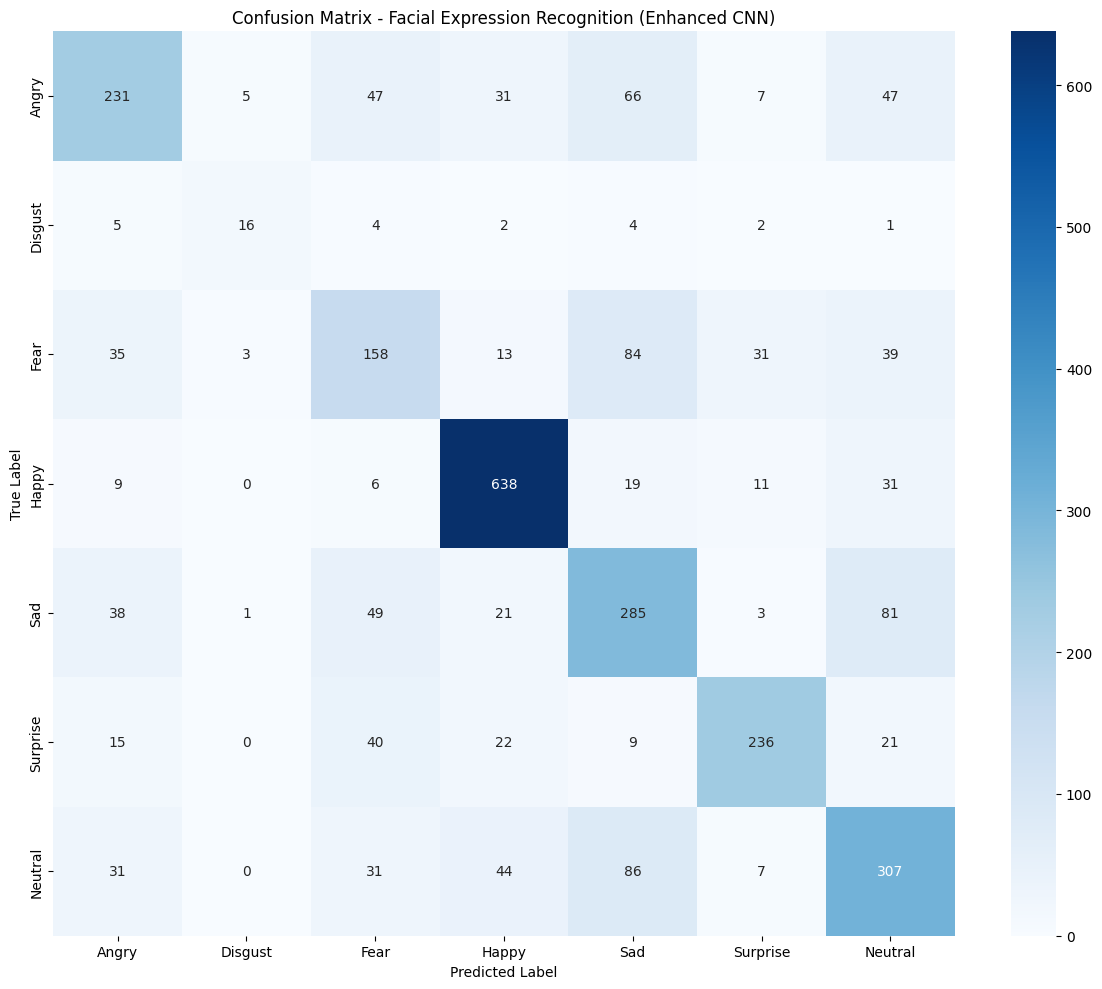


Final Results:
Best Validation Accuracy: 65.20%
Test Accuracy: 65.15%


In [28]:
print("\nEvaluating best model on test set...")
best_model_files = [f for f in os.listdir('.') if f.startswith('best_model_') and f.endswith('.pt')]
if best_model_files:
    latest_model = max(best_model_files, key=lambda x: os.path.getctime(x))
    test_acc, test_preds, test_targets = evaluate_model_on_testset(latest_model, test_loader)

    print(f"\nFinal Results:")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"Test Accuracy: {test_acc:.2f}%")
else:
    print("No model file found!")

In [29]:
import glob

In [34]:
class FER2013Dataset(Dataset):
    def __init__(self, data_source, transform=None, is_test=False):
        if isinstance(data_source, str):
           self.data = pd.read_csv(data_source)
        else:
           self.data = data_source
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.iloc[idx]['pixels']

        # For test data, there might not be an emotion column
        if self.is_test or 'emotion' not in self.data.columns:
            emotion = -1  # Dummy label for test data
        else:
            emotion = self.data.iloc[idx]['emotion']

        image = np.array([int(pixel) for pixel in pixels.split()]).reshape(48, 48)
        image = image.astype(np.float32) / 255.0

        if self.transform:
            image = self.transform(image)
        else:
            image = torch.FloatTensor(image).unsqueeze(0)

        return image, emotion

In [35]:
def generate_submission(model_path, test_csv_path, output_file='submission.csv', batch_size=64):
    # Load the saved model
    checkpoint = torch.load(model_path, map_location=device)

    model_config = checkpoint['model_config']
    model = EnhancedCNN(
        dropout_rate=model_config['dropout_rate'],
        hidden_dim=model_config['hidden_dim']
    ).to(device)

    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Create test transform (no augmentation)
    test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Load test dataset with is_test=True
    test_dataset = FER2013Dataset(test_csv_path, transform=test_transform, is_test=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Make predictions
    all_preds = []

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())

    # Create submission DataFrame
    submission = pd.DataFrame({
        'id': range(len(all_preds)),
        'emotion': all_preds
    })

    # Save to CSV
    submission.to_csv(output_file, index=False)
    print(f"Submission saved to {output_file}")
    print(f"Total predictions: {len(all_preds)}")

    return submission

In [36]:
# Find your best model file
model_files = glob.glob("best_model_*.pt")
if model_files:
    latest_model = max(model_files, key=lambda x: os.path.getctime(x))
    print(f"Using model: {latest_model}")

    # Generate submission
    submission_df = generate_submission(
        model_path=latest_model,
        test_csv_path='test.csv',
        output_file='submission.csv',
        batch_size=64
    )

    print("\nSubmission file created successfully!")

else:
    print("No trained model found! Make sure you have a best_model_*.pt file.")

Using model: best_model_d86eh1xs.pt
Submission saved to submission.csv
Total predictions: 7178

Submission file created successfully!
